In [1]:
from record_preprocess import *

/Users/purchaser/miniforge3/envs/MMKP-solver/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

load_all_play_records()

Data sources loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/plots/datas/reports/Player_trace_cluster_64_data_source_ali_static_MMKP_RR_partition_2023-02-28-19-20-18/json loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/plots/datas/reports/Player_trace_cluster_64_data_source_ali_static_MMKP_2023-02-28-18-35-41/json loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/plots/datas/reports/Player_trace_cluster_64_data_source_phi_static_MMKP_RR_partition_2023-02-28-21-32-14/json loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/plots/datas/reports/Player_trace_cluster_64_data_source_phi_static_MMKP_RR_distribution_2023-02-28-22-17-06/json loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/plots/datas/reports/Player_trace_cluster_64_data_source_phi_trace_MMKP_2023-02-28-15-14-10/json loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/plots/datas/reports/Player_trace_cluster_64_data_source_phi_trace_MMKP_RR_partition

In [14]:

def plot_random_placement_box(ax, data_source: DataSourceName, schedulers: List[SchedulerName],
                              session_mode: SessionMode = SessionMode.RandomPlacement,
                              locator: float = 30,
                              percentage_formatter: bool = False,
                              extract_item=None,
                              ylabel=None):
    box_data = list()
    cluster_name = ClusterName.Cluster64
    for scheduler in schedulers:
        play_record = extract_play_record(session_mode,
                                          cluster_name=cluster_name,
                                          data_source_name=data_source,
                                          scheduler_name=scheduler)
        assert len(play_record) == 1
        play_record = play_record[0]
        items = list()
        for stat in play_record.assignment_statistics:
            if extract_item is None:
                items.append(stat.profit * 2)
            else:
                items.append(extract_item(stat))
        print(f"scheduler {scheduler}, avg item values: {np.mean(items)}")
        box_data.append(items)

    handles = list()

    bp = ax.boxplot(box_data, patch_artist=True, notch="True")
    for i, patch in enumerate(bp["boxes"]):
        scheduler = schedulers[i]
        spec = scheduler_to_spec(scheduler_name=scheduler)
        color = spec["color"]
        patch.set_facecolor(color)
        hatch = "/"
        patch.set_hatch(hatch)
        handle = Patch(
            facecolor=color,
            edgecolor="black",
            label=spec["label"],
            hatch=hatch
        )
        handles.append(handle)

    for whisker in bp['whiskers']:
        whisker.set(color='black',
                    linewidth=1.5,
                    linestyle=":")

    # changing color and linewidth of
    # caps
    for cap in bp['caps']:
        cap.set(color='black',
                linewidth=2)

    # changing color and linewidth of
    # medians
    for median in bp['medians']:
        median.set(color='black',
                   linewidth=3)

    # changing style of fliers
    for flier in bp['fliers']:
        flier.set(marker='D',
                  color="black",
                  alpha=0.5)

    # xtick_labels = [scheduler_to_spec(scheduler)["label"] for scheduler in schedulers]
    # ax.set_xticklabels(xtick_labels, rotation=45)
    if percentage_formatter:
        ax.yaxis.set_major_formatter(plt_ticker.FuncFormatter('{0:.0%}'.format))
    y_major_loc = plt_ticker.MultipleLocator(base=locator)
    ax.yaxis.set_major_locator(y_major_loc)
    ax.yaxis.grid(True)
    ax.set_xticks([])
    # ax.set_ylabel("$\hat{T}_{total}$")
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Schedulers")
    ax.set_xlabel(data_source_to_spec(data_source_name=data_source)["label"])
    return handles


def plot_random_placement_boxes(filename: str,
                                ylabel: str,
                                locator: float = 30, schedulers: Optional[List[SchedulerName]] = None,
                                percentage_formatter: bool = False, extract_item=None):
    original_fontsize = mpl.rcParams["font.size"]
    mpl.rcParams.update({'font.size': 26})
    if schedulers is None:
        schedulers = [SchedulerName.SPREAD,
                      SchedulerName.KubeShare,
                      SchedulerName.Gavel,
                      SchedulerName.Tiresias,
                      SchedulerName.AFS,
                      SchedulerName.Kubernetes,
                      SchedulerName.SPREAD_PRIME]
    data_source_names = [
        DataSourceName.DataSourceAliSta,
        DataSourceName.DataSourcePhiSta,
    ]
    col = 2
    fig, axes = plt.subplots(1, col, figsize=(22, 8))
    handles = None
    for i, data_source_name in enumerate(data_source_names):
        if extract_item is None:
            handles = plot_random_placement_box(axes[i % col], data_source_name, schedulers, locator=locator,
                                                percentage_formatter=percentage_formatter,
                                                extract_item=None, ylabel=ylabel)
        else:
            handles = plot_random_placement_box(axes[i % col], data_source_name, schedulers, locator=locator,
                                                percentage_formatter=percentage_formatter,
                                                ylabel=ylabel,
                                                extract_item=extract_item(
                                                    data_source=data_source_dict[data_source_name]))

    fig.tight_layout()
    lgd = fig.legend(handles=handles, loc=(0.01, 0.9), ncol=len(handles))
    lgd.get_frame().set_alpha(None)
    fig.subplots_adjust(top=0.87)
    save_fig(fig, output_path(f"{filename}.pdf"))
    mpl.rcParams.update({'font.size': original_fontsize})


def plot_spreading_distribution_bar():
    original_fontsize = mpl.rcParams["font.size"]
    mpl.rcParams.update({'font.size': 24})
    fig, ax = plt.subplots(figsize=(12, 4))
    width = 0.3
    cluster_name = ClusterName.Cluster64
    items = list()
    data_source_names = [
        DataSourceName.DataSourceAliSta,
        DataSourceName.DataSourcePhiSta,
    ]
    rfd_improvements = list()
    # total_profit = cluster_name_to_spec(cluster_name)["total_profit"]
    for i, data_source_name in enumerate(data_source_names):
        total_deployed_jobs = 0
        total_spread_jobs = 0
        play_record = extract_play_record(SessionMode.RandomPlacement,
                                          cluster_name=cluster_name,
                                          data_source_name=data_source_name,
                                          scheduler_name=SchedulerName.SPREAD)
        assert len(play_record) == 1
        play_record = play_record[0]
        for stat in play_record.assignment_statistics:
            total_deployed_jobs += stat.deployed_job_size
            total_spread_jobs += stat.deployed_dist_job_size
        items.append(total_spread_jobs / total_deployed_jobs)

        no_split_play_record = extract_play_record(SessionMode.RandomPlacement,
                                                   cluster_name=cluster_name,
                                                   data_source_name=data_source_name,
                                                   scheduler_name=SchedulerName.SPREAD_PRIME)
        assert len(no_split_play_record) == 1
        no_split_play_record = no_split_play_record[0]

        def get_avg_rfd(rc):
            profits = list()
            for st in rc.assignment_statistics:
                profits.append(st.profit)
            return np.mean(profits)

        rfd_sp = get_avg_rfd(play_record)
        rfd_sp_no_split = get_avg_rfd(no_split_play_record)

        rfd_improvements.append(rfd_sp - rfd_sp_no_split)

    X = np.arange(len(data_source_names))
    spec = scheduler_to_spec(scheduler_name=SchedulerName.MMKP_strict)
    ax.bar(X, items,
           width=width,
           color=spec["color"],
           label="Ratio of Spread Jobs",
           edgecolor="black",
           hatch="/")

    xticks = [data_source_to_spec(data_source_name)["label"] for data_source_name in data_source_names]
    ax.tick_params(axis='y', labelcolor=spec["color"])
    ax.set_xticks(X, xticks)
    ax.yaxis.set_major_formatter(plt_ticker.FuncFormatter('{0:.0%}'.format))
    ax.set_ylabel("Ratio of Spread Jobs", color=spec["color"])
    ax.set_xlabel("Workloads")
    # ax.yaxis.grid(True)

    ax_ratio = ax.twinx()
    # ax_ratio.set_ylim([0., 1.])
    ratio_color = colors[2]
    ax_ratio.set_ylabel(r"$\hat{T}$ Improvement", color=ratio_color)
    ax_ratio.plot(
        X, rfd_improvements,
        linestyle="solid", marker="o",
        label="$\hat{T}$ Improvement",
        color=ratio_color
    )
    ax_ratio.yaxis.set_major_formatter(plt_ticker.FuncFormatter('{0:.0%}'.format))
    ax_ratio.tick_params(axis='y', labelcolor=ratio_color)
    fig.legend(loc=(0.2, 0.6))
    # ax.xaxis.grid(True)
    fig.tight_layout()
    save_fig(fig, output_path("random_placement_spreading_distribution.pdf"))
    mpl.rcParams.update({'font.size': original_fontsize})


def plot_spread_distribution_bar_2():
    original_fontsize = mpl.rcParams["font.size"]
    mpl.rcParams.update({'font.size': 24})
    schedulers = [SchedulerName.SPREAD,
                  SchedulerName.SPREAD_RR_PARTI,
                  SchedulerName.SPREAD_RR_DISTRI,
                  SchedulerName.SPREAD_RR_PARTI_DISTRI]
    cluster_name = ClusterName.Cluster64
    fig, ax = plt.subplots(figsize=(8, 4))
    data_source_names = [
        DataSourceName.DataSourceAliSta,
        DataSourceName.DataSourcePhiSta,
    ]
    X = np.arange(len(data_source_names))
    width = 0.2
    schedulers_to_spread_ratios = defaultdict(list)
    schedulers_to_in_node_spread_ratios = defaultdict(list)
    schedulers_to_improvement = defaultdict(list)
    for i, data_source_name in enumerate(data_source_names):
        for scheduler in schedulers:
            play_record = extract_play_record(
                mode=SessionMode.RandomPlacement,
                data_source_name=data_source_name,
                cluster_name=cluster_name,
                scheduler_name=scheduler)
            assert len(play_record) == 1
            play_record = play_record[0]
            total_deployed_jobs = 0
            total_spread_jobs = 0
            total_cross_node_spread_jobs = 0
            for stat in play_record.assignment_statistics:
                total_deployed_jobs += stat.deployed_job_size
                total_spread_jobs += stat.deployed_spread_job_size
                total_cross_node_spread_jobs += stat.deployed_cross_node_job_size
            total_in_node_spread_jobs = total_spread_jobs - total_cross_node_spread_jobs
            schedulers_to_spread_ratios[scheduler].append(total_spread_jobs / total_deployed_jobs)
            schedulers_to_in_node_spread_ratios[scheduler].append(1. * total_in_node_spread_jobs / total_deployed_jobs)

            no_spread_play_record = extract_play_record(SessionMode.RandomPlacement,
                                                        cluster_name=cluster_name,
                                                        data_source_name=data_source_name,
                                                        scheduler_name=SchedulerName.SPREAD_PRIME)
            assert len(no_spread_play_record) == 1
            no_spread_play_record = no_spread_play_record[0]

            def get_avg_profit(rc):
                profits = list()
                for st in rc.assignment_statistics:
                    profits.append(st.profit * 2)
                return np.mean(profits)

            pfs_sp = get_avg_profit(play_record)
            pfs_no_sp = get_avg_profit(no_spread_play_record)

            schedulers_to_improvement[scheduler].append(pfs_sp - pfs_no_sp)

    print(f"schedulers_to_spread_ratios: {schedulers_to_spread_ratios}")
    print(f"schedulers_to_in_node_spread_ratios: {schedulers_to_in_node_spread_ratios}")

    bottom = 0.5
    hatch = "/"
    for i, scheduler in enumerate(schedulers):
        ratios = schedulers_to_spread_ratios[scheduler]
        spec = scheduler_to_spec(scheduler_name=scheduler)
        print(f"{scheduler}: ", np.array(ratios))
        ax.bar(
            X + i * width,
            np.array(ratios),
            width=width,
            color=spec["color"],
            label=spec["label"],
            hatch=hatch
        )
    # ax.spines['bottom'].set_position(('data', bottom))
    ax.set_xticks(X + (width / 2) * (len(schedulers) - 1),
                  [data_source_to_spec(data_source_name=dn)["label"] for dn in data_source_names])
    y_major_loc = plt_ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(y_major_loc)
    fig.tight_layout()
    fig.legend(loc=(0.05, 0.70), ncol=len(schedulers) // 2)
    fig.subplots_adjust(top=0.60)
    ax.set_ylabel('Ratio of Spread Jobs')
    ax.set_xlabel('Workloads')
    ax.set_yticks([0, 0.2, 0.4, 0.6])
    ax.yaxis.grid(True)
    ax.yaxis.set_major_formatter(plt_ticker.FuncFormatter('{0:.0%}'.format))

    ax_ratio = ax.twinx()
    # ax_ratio.set_ylim([0., 1.])
    ratio_color = colors[4]
    ax_ratio.set_ylabel(r"Ratio of In-node Spread Jobs", color=ratio_color)
    for i, scheduler in enumerate(schedulers):
        ratios = schedulers_to_in_node_spread_ratios[scheduler]
        print(f"{scheduler}: ", np.array(ratios))
        ax_ratio.plot(
            X + i * width,
            ratios,
            linestyle="solid", marker="*",
            markersize=10,
            linewidth=0,
            # label="$\hat{T}$ Improvement",
            color=ratio_color
        )
    ax_ratio.yaxis.set_major_formatter(plt_ticker.FuncFormatter('{0:.0%}'.format))
    ax_ratio.set_yticks([0, 0.2, 0.4, 0.6])
    y_major_loc = plt_ticker.MultipleLocator(base=0.2)
    ax_ratio.yaxis.set_major_locator(y_major_loc)
    ax_ratio.tick_params(axis='y', labelcolor=ratio_color)

    save_fig(fig, output_path(f"RR_PD_spread_ratio_bar.pdf"))
    mpl.rcParams.update({'font.size': original_fontsize})


scheduler SchedulerName.SPREAD, avg item values: 131.6557834267808
scheduler SchedulerName.SPREAD_RR_PARTI, avg item values: 130.14294733790118
scheduler SchedulerName.SPREAD_RR_DISTRI, avg item values: 126.07362051112096
scheduler SchedulerName.SPREAD_RR_PARTI_DISTRI, avg item values: 122.66269160789436
scheduler SchedulerName.SPREAD_PRIME, avg item values: 121.96145054858957
scheduler SchedulerName.SPREAD, avg item values: 129.4430380083863
scheduler SchedulerName.SPREAD_RR_PARTI, avg item values: 127.83285332575976
scheduler SchedulerName.SPREAD_RR_DISTRI, avg item values: 123.69496483236136
scheduler SchedulerName.SPREAD_RR_PARTI_DISTRI, avg item values: 120.07658468610349
scheduler SchedulerName.SPREAD_PRIME, avg item values: 119.16005237789842


scheduler SchedulerName.SPREAD, avg item values: 131.6557834267808
scheduler SchedulerName.KubeShare, avg item values: 107.85182170847992
scheduler SchedulerName.Gavel, avg item values: 120.80200663128576
scheduler SchedulerName.Tiresias, avg item values: 105.18299388239724
scheduler SchedulerName.AFS, avg item values: 100.14824402675724
scheduler SchedulerName.Kubernetes, avg item values: 80.14307521484828
scheduler SchedulerName.SPREAD_PRIME, avg item values: 121.96145054858957
scheduler SchedulerName.SPREAD, avg item values: 129.4430380083863
scheduler SchedulerName.KubeShare, avg item values: 105.81143283061068
scheduler SchedulerName.Gavel, avg item values: 122.56677958218106
scheduler SchedulerName.Tiresias, avg item values: 106.84320548987758
scheduler SchedulerName.AFS, avg item values: 99.20442463168425
scheduler SchedulerName.Kubernetes, avg item values: 81.94724249551233
scheduler SchedulerName.SPREAD_PRIME, avg item values: 119.16005237789842


scheduler SchedulerName.SPREAD, avg item values: 0.9715215104166666
scheduler SchedulerName.KubeShare, avg item values: 0.7731724218749999
scheduler SchedulerName.Gavel, avg item values: 0.8621191145833335
scheduler SchedulerName.Tiresias, avg item values: 0.7570386979166668
scheduler SchedulerName.AFS, avg item values: 0.8702220833333334
scheduler SchedulerName.Kubernetes, avg item values: 0.5872623177083333
scheduler SchedulerName.SPREAD_PRIME, avg item values: 0.8548640364583332
scheduler SchedulerName.SPREAD, avg item values: 0.9731969010416667
scheduler SchedulerName.KubeShare, avg item values: 0.7713184895833333
scheduler SchedulerName.Gavel, avg item values: 0.8655889062499998
scheduler SchedulerName.Tiresias, avg item values: 0.7593576041666666
scheduler SchedulerName.AFS, avg item values: 0.8675474218750001
scheduler SchedulerName.Kubernetes, avg item values: 0.5819303385416666


scheduler SchedulerName.SPREAD_PRIME, avg item values: 0.8521253124999998
scheduler SchedulerName.SPREAD, avg item values: 0.9715215104166666
scheduler SchedulerName.SPREAD_RR_PARTI, avg item values: 0.9432115277777777
scheduler SchedulerName.SPREAD_RR_DISTRI, avg item values: 0.9597517881944444
scheduler SchedulerName.SPREAD_RR_PARTI_DISTRI, avg item values: 0.9088155468750001
scheduler SchedulerName.SPREAD_PRIME, avg item values: 0.8548640364583332
scheduler SchedulerName.SPREAD, avg item values: 0.9731969010416667
scheduler SchedulerName.SPREAD_RR_PARTI, avg item values: 0.9428456684027776
scheduler SchedulerName.SPREAD_RR_DISTRI, avg item values: 0.9607261284722222
scheduler SchedulerName.SPREAD_RR_PARTI_DISTRI, avg item values: 0.9092831510416667


scheduler SchedulerName.SPREAD_PRIME, avg item values: 0.8521253124999998
schedulers_to_spread_ratios: defaultdict(<class 'list'>, {<SchedulerName.SPREAD: 'MMKP'>: [0.47920615453227783, 0.4917350725289554], <SchedulerName.SPREAD_RR_PARTI: 'MMKP_RR_partition'>: [0.3396326573946279, 0.3512847965738758], <SchedulerName.SPREAD_RR_DISTRI: 'MMKP_RR_distribution'>: [0.5584059181481923, 0.5793660359165964], <SchedulerName.SPREAD_RR_PARTI_DISTRI: 'MMKP_RR_partition_distribution'>: [0.37998157106657454, 0.3901220220801859]})
schedulers_to_in_node_spread_ratios: defaultdict(<class 'list'>, {<SchedulerName.SPREAD: 'MMKP'>: [0.47017504738543875, 0.4831890250759024], <SchedulerName.SPREAD_RR_PARTI: 'MMKP_RR_partition'>: [0.17602717910606222, 0.17708779443254818], <SchedulerName.SPREAD_RR_DISTRI: 'MMKP_RR_distribution'>: [0.5572127431094142, 0.5784018319874653], <SchedulerName.SPREAD_RR_PARTI_DISTRI: 'MMKP_RR_partition_distribution'>: [0.22506334945865009, 0.2271934921557234]})
SchedulerName.SPREAD: 

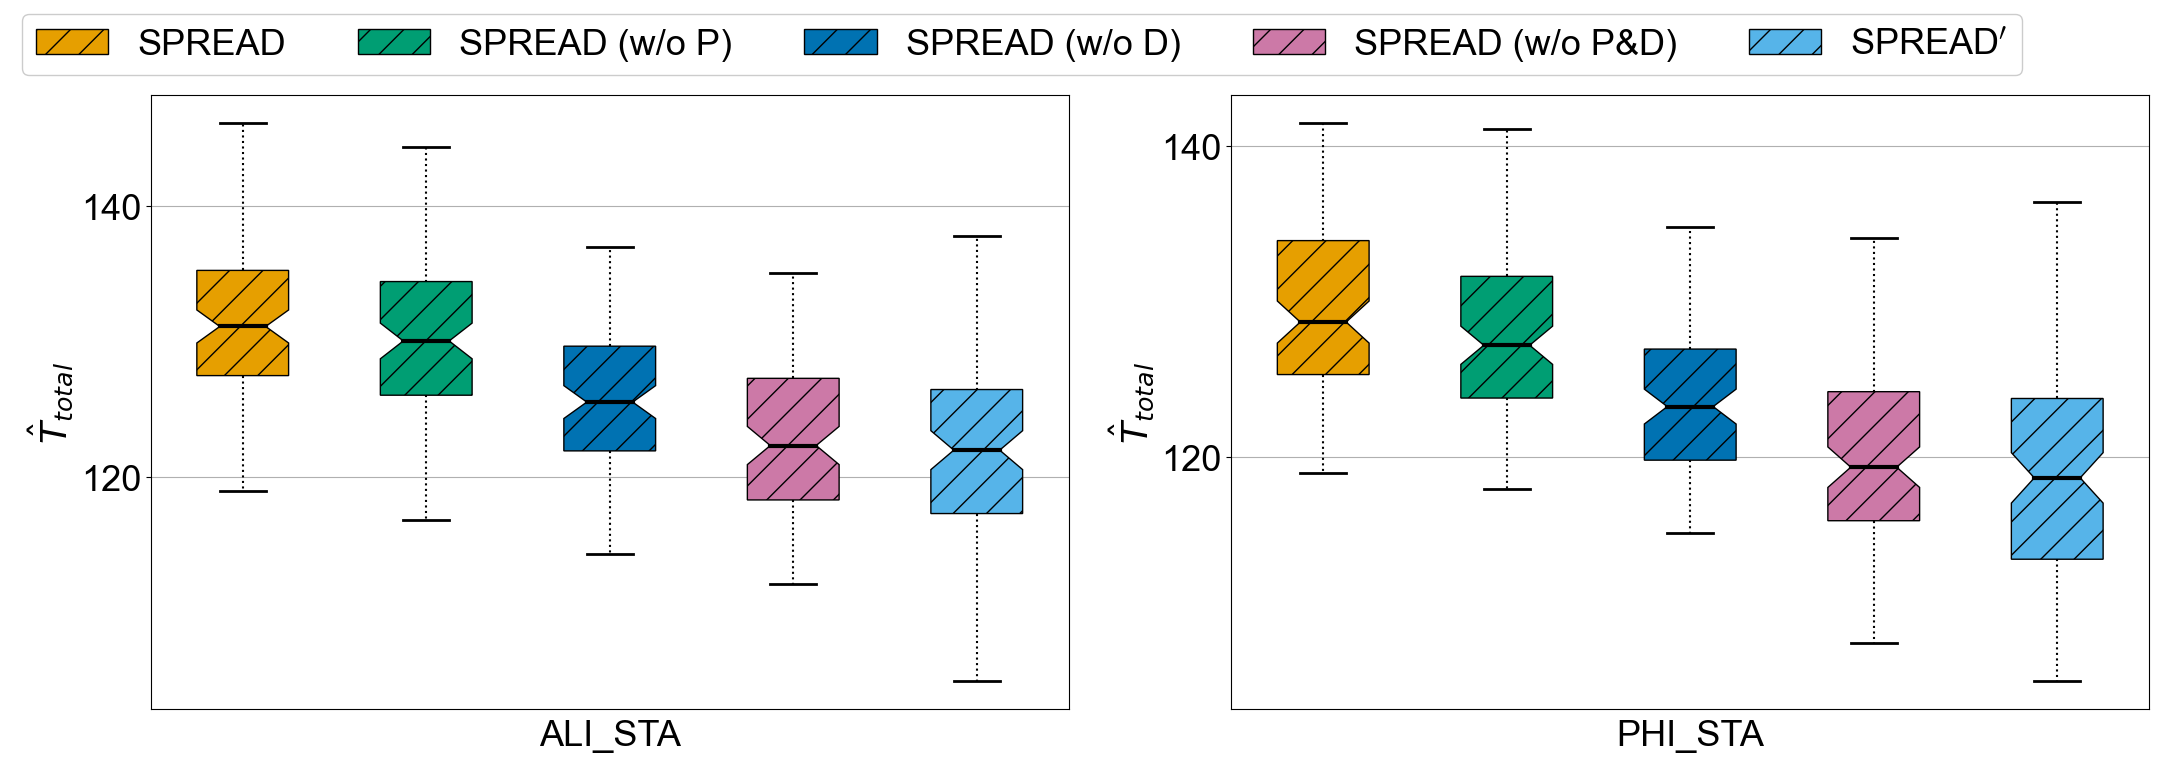

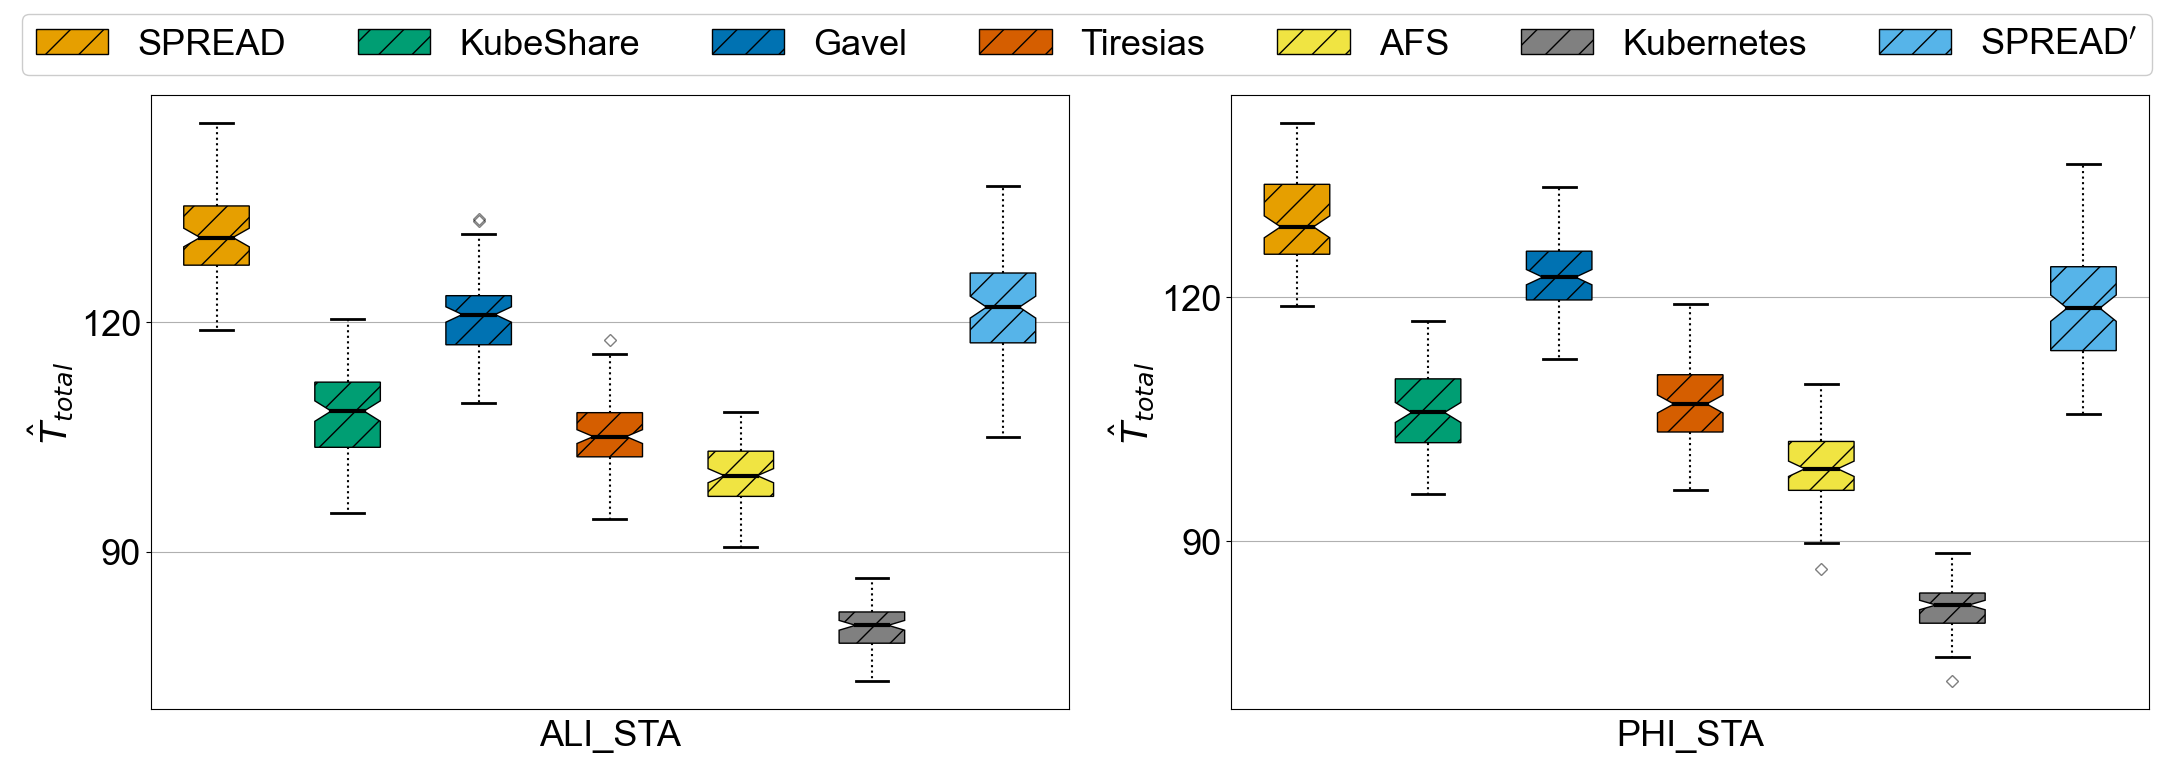

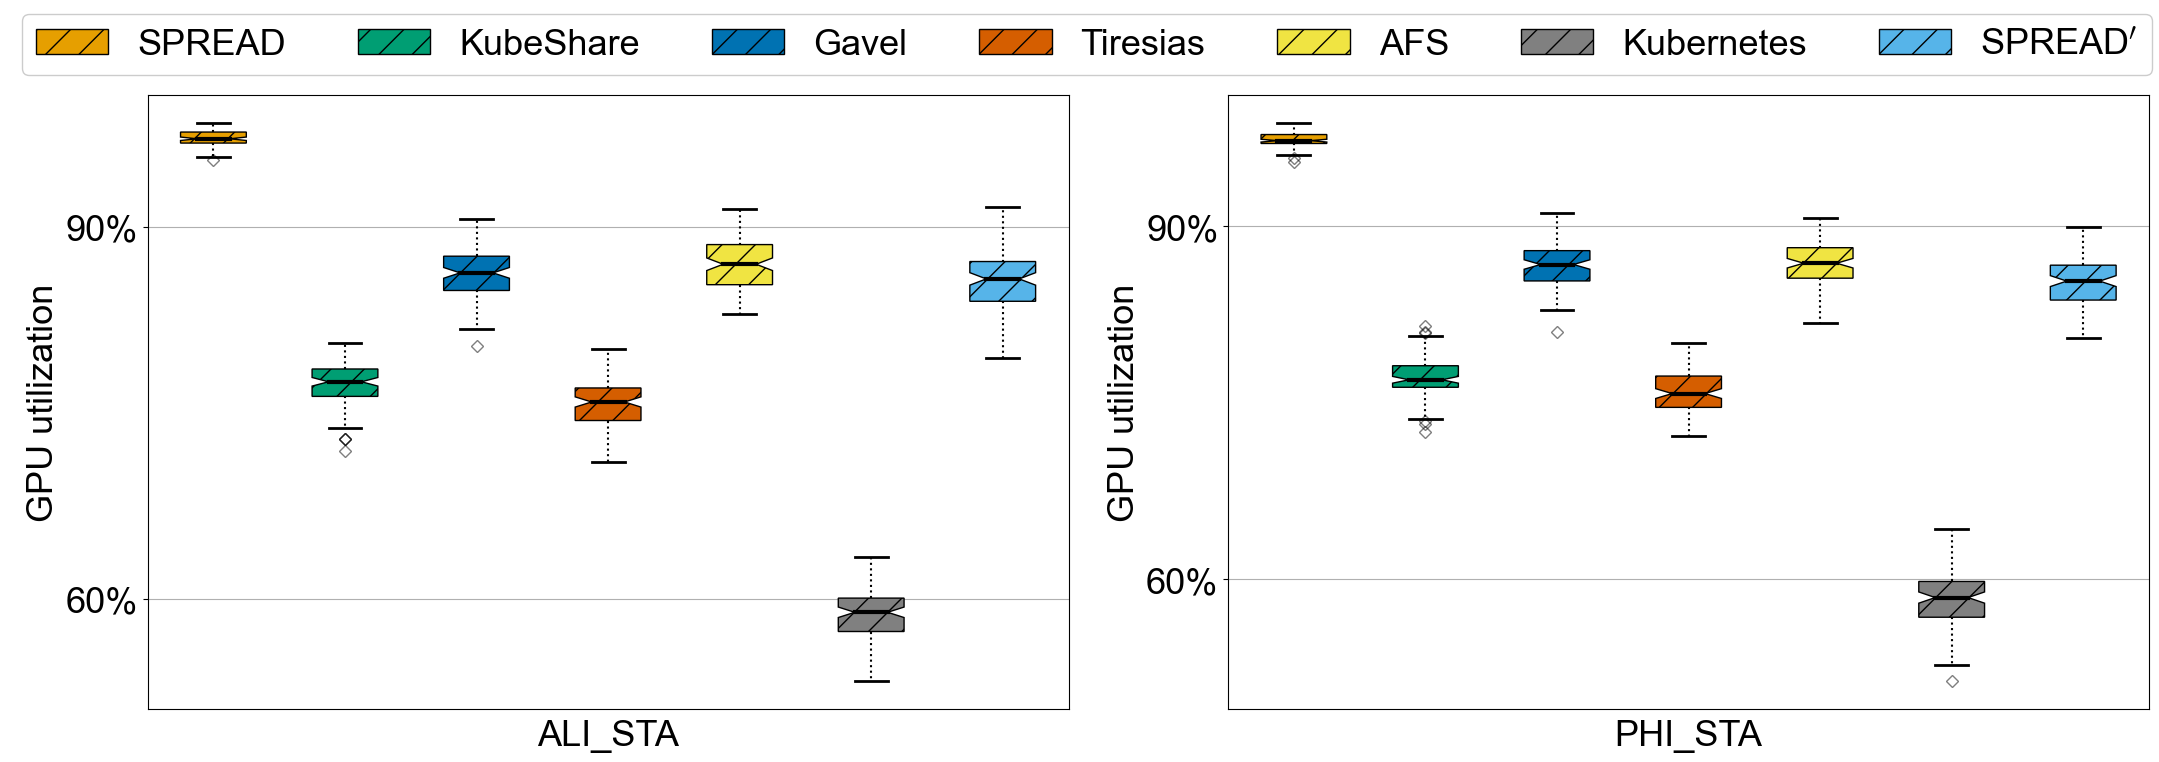

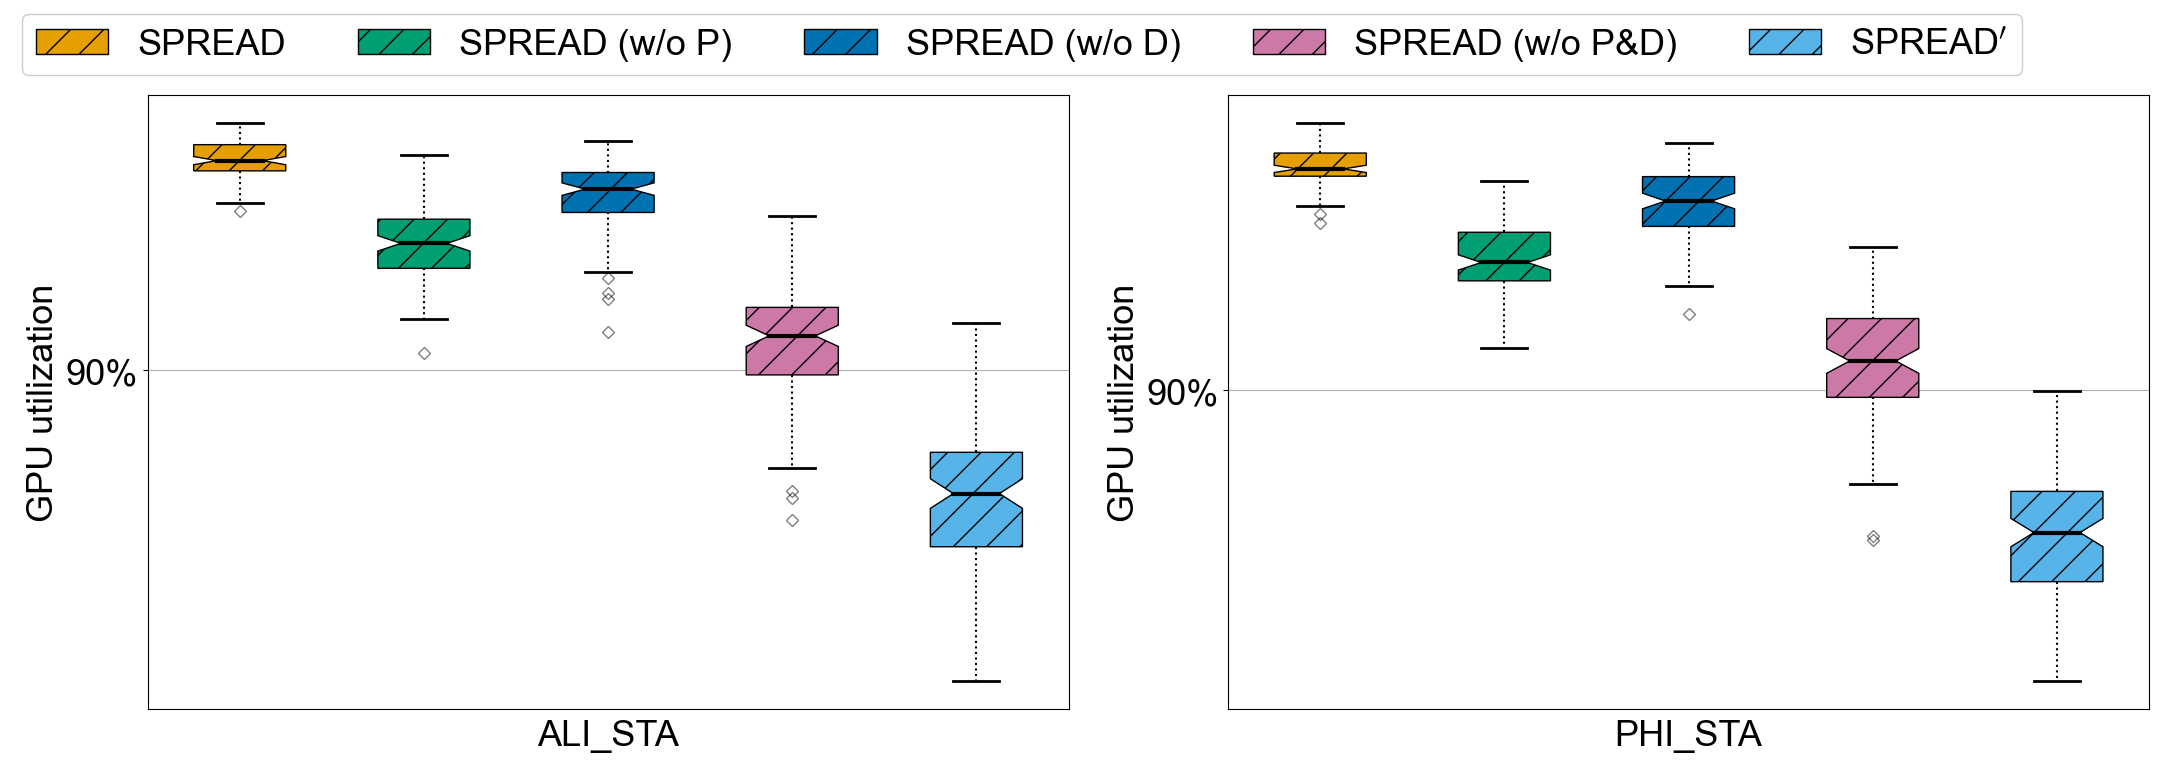

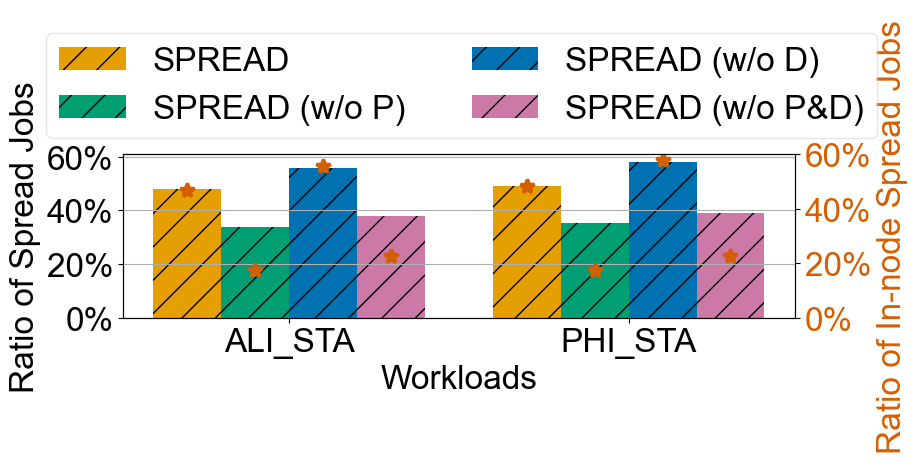

In [15]:
PD_schedulers = [SchedulerName.SPREAD,
                 SchedulerName.SPREAD_RR_PARTI,
                 SchedulerName.SPREAD_RR_DISTRI,
                 SchedulerName.SPREAD_RR_PARTI_DISTRI,
                 SchedulerName.SPREAD_PRIME]
plot_random_placement_boxes("random_PD_placement_boxes.pdf", ylabel="$\hat{T}_{total}$", schedulers=PD_schedulers,
                            locator=20)
plot_random_placement_boxes("random_placement_boxes.pdf", ylabel="$\hat{T}_{total}$")


def extract_item(data_source: DataSource):
    def do(assignment_stat):
        utils = list()
        for _, d in assignment_stat.job_ID_to_deploy.items():
            util = data_source.job_task_computation_utilization(job_ID=d.job_ID, GPU_type=GPUType.RTX_2080Ti,
                                                                comp_req=d.comp_req, worker_count=d.worker_count,
                                                                cross_node=d.cross_node)
            util *= d.worker_count
            utils.append(util / (64 * 100))
        return np.sum(utils)

    return do


plot_random_placement_boxes("random_placement_util_boxes",
                            ylabel="GPU utilization",
                            extract_item=extract_item, locator=0.3,
                            percentage_formatter=True)
plot_random_placement_boxes("random_PD_placement_util_boxes",
                             ylabel="GPU utilization",
                            schedulers=PD_schedulers,
                            extract_item=extract_item, locator=0.3,
                            percentage_formatter=True)
# plot_spreading_distribution_bar()
plot_spread_distribution_bar_2()